In [2]:
from quri_parts.core.operator import Operator, pauli_label, PAULI_IDENTITY, PauliLabel
from scipy.optimize import minimize
import numpy as np
from quri_parts.circuit import LinearMappedUnboundParametricQuantumCircuit
from quri_parts.core.state import quantum_state
from quri_parts.qulacs.estimator import create_qulacs_vector_estimator
import networkx as nx

# Graph Isomorphism Problem

The **Graph Isomorphism (GI)** problem is a well-known problem in theoretical computer science and combinatorics. Unlike NP-complete problems, GI is in NP but has not been proven to be either in P or NP-complete, making it a fascinating intermediate problem. The goal is to determine whether two given graphs are structurally identical, meaning there exists a bijective mapping between their vertex sets that preserves edge connectivity.

## Applications

- **Chemistry**: Checking whether two molecular graphs represent the same compound.  
- **Pattern Recognition**: Matching structural patterns in images or graphs.  
- **Cryptography**: Designing protocols based on the hardness of GI.  

---

## Problem Definition

Let  
$G_{1} = (V_{1}, E_{1}),\quad  
G_{2} = (V_{2}, E_{2})$  
be two undirected graphs with $|V_{1}| = |V_{2}| = n$. We ask whether there exists a bijection  
$\pi : V_{1} \longrightarrow V_{2}$  
such that for **every** pair $(u,v)$:
$$(u,v)\in E_{1} \quad\Longleftrightarrow\quad (\pi(u),\pi(v))\in E_{2}.$$

If such a $\pi$ exists, we say $G_{1}$ and $G_{2}$ are **isomorphic**, denoted $G_{1}\cong G_{2}$.

---

## Adjacency Matrix Formulation

Number the vertices of each graph from $1$ to $n$. Define their **adjacency matrices**:

$$
A^{(1)} = \bigl[a^{(1)}_{ij}\bigr],\quad
a^{(1)}_{ij} =
\begin{cases}
1, & (i,j)\in E_{1},\\
0, & \text{otherwise},
\end{cases}
$$

$$
A^{(2)} = \bigl[a^{(2)}_{ij}\bigr],\quad
a^{(2)}_{ij} =
\begin{cases}
1, & (i,j)\in E_{2},\\
0, & \text{otherwise}.
\end{cases}
$$

---

## Permutation Matrix and Matrix Equation

A bijection $\pi$ on the vertex set corresponds to an $n\times n$ **permutation matrix** $P$, where

$$
P_{k\ell} =
\begin{cases}
1, & \ell = \pi(k),\\
0, & \text{otherwise}.
\end{cases}
$$

Such a $P$ satisfies $P^T = P^{-1}$ and $P^T P = P P^T = I_{n}$. The key fact is:

> **$G_{1}\cong G_{2}$** if and only if there exists a permutation matrix $P$ such that  
> $$\boxed{A^{(2)} = P^T\,A^{(1)}\,P.}$$

Equivalently,  
$$A^{(1)} = P\,A^{(2)}\,P^T.$$

---

### Why It Works

1. If $\pi$ is an isomorphism, then  
   $$(i,j)\in E_{1} \iff (\pi(i),\pi(j))\in E_{2}.$$
2. Conjugation by $P$ permutes rows and columns:  
   $$
   (P^T A^{(1)} P)_{k\ell}
   = \sum_{i,j} P^T_{k i}\,a^{(1)}_{ij}\,P_{j\ell}
   = a^{(1)}_{\pi^{-1}(k),\,\pi^{-1}(\ell)}
   = a^{(2)}_{k\ell}.
   $$

---

## Summary

- **Graph Isomorphism** asks whether two graphs $G_{1}$ and $G_{2}$ differ only by a relabeling of vertices.  
- By passing to adjacency matrices $A^{(1)},A^{(2)}$, the problem reduces to finding a **permutation matrix** $P$ with  
  $$A^{(2)} = P^T A^{(1)} P.$$  
- If such a $P$ exists, $G_{1}$ and $G_{2}$ are isomorphic; otherwise they are distinct.

This matrix-based view casts GI as a **permutation-similarity** decision problem on $\{0,1\}$-matrices.

### Graph Isomorphism demo  

In [202]:
# Build an example graph
nodes = 4

graph1 = {
    'nodes': list(range(nodes)),
    'edges': [
        (1, 0), (2, 1), (3, 2), (0, 3)
    ]
}

graph2 = {
    'nodes': list(range(nodes)),
    'edges': [
        (1, 0), (0, 2), (3, 2), (1, 3)
    ]
}

graph3 = {
    'nodes': list(range(nodes)),
    'edges': [
        (0, 1), (0, 2), (3, 2)#, (1, 3)
    ]
}

G1 = nx.Graph()
G1.add_nodes_from(graph1['nodes'])
G1.add_edges_from(graph1['edges'])

G2 = nx.Graph()
G2.add_nodes_from(graph2['nodes'])
G2.add_edges_from(graph2['edges'])

G3 = nx.Graph()
G3.add_nodes_from(graph3['nodes'])
G3.add_edges_from(graph3['edges'])

nodes = G1.nodes()
num_qubits = G1.number_of_nodes()**2

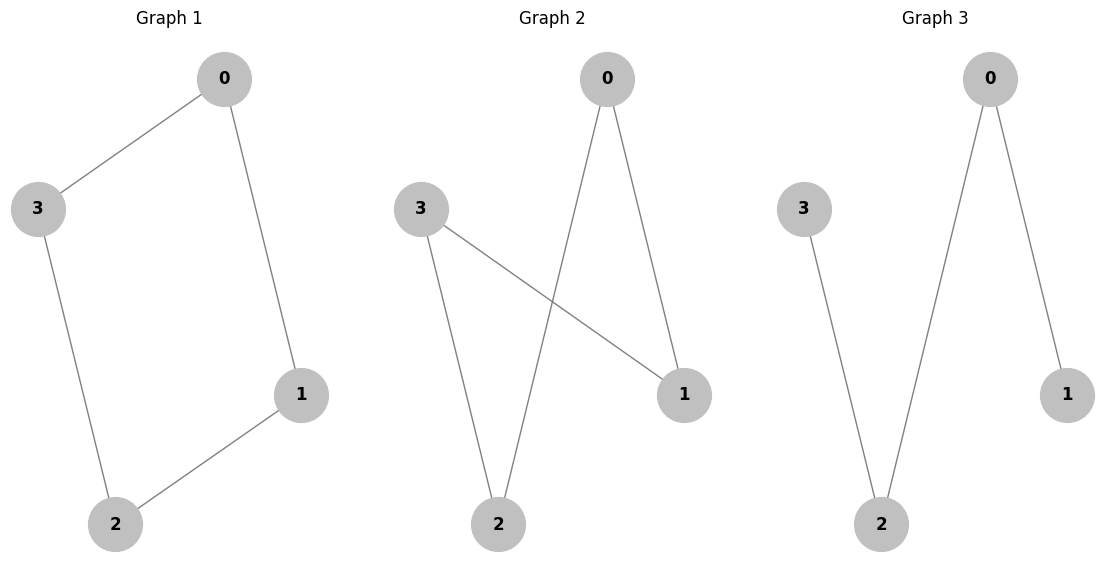

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

full_graph_color = "#C0C0C0"
pos = nx.spring_layout(G1, seed=42)
# Create a color map for the nodes
fig, axes = plt.subplots(1, 3, figsize=(14, 7))

nx.draw(G1, pos, with_labels=True, node_color=full_graph_color, edge_color="gray",
        node_size=1500, font_size=12, font_weight="bold", ax=axes[0])
axes[0].set_title("Graph 1")

nx.draw(G2, pos, with_labels=True, node_color=full_graph_color, edge_color="gray",
        node_size=1500, font_size=12, font_weight="bold", ax=axes[1])
axes[1].set_title("Graph 2")

nx.draw(G3, pos, with_labels=True, node_color=full_graph_color, edge_color="gray",
        node_size=1500, font_size=12, font_weight="bold", ax=axes[2])
axes[2].set_title("Graph 3")

plt.show()

## QUBO Hamiltonian for Graph Isomorphism

To solve the Graph Isomorphism problem using QUBO, we define a binary matrix of variables $x_{v,i} \in \{0,1\}$ such that:

- $x_{v,i} = 1$ if vertex $v$ in $G_2$ is mapped to vertex $i$ in $G_1$
- $x_{v,i} = 0$ otherwise

This formulation ensures a bijection between the two graphs’ vertex sets and enforces edge consistency.  
The total energy function is composed of two parts: a **bijective constraint Hamiltonian** and an **edge consistency penalty Hamiltonian**.

---

### 1. Bijectivity Constraint:

$$
H_A = A \sum_v \left( 1 - \sum_i x_{v,i} \right)^2
\;+\;
A \sum_i \left( 1 - \sum_v x_{v,i} \right)^2
$$

- The first term ensures that every vertex in $G_2$ maps to **exactly one** vertex in $G_1$.
- The second term ensures that every vertex in $G_1$ receives **exactly one** mapping from $G_2$.
- The parameter **$A > 0$** controls the penalty for violating the bijection.

---

### 2. Edge Consistency Penalty:

$$
H_B = B \sum_{\substack{i j \notin E_1 \\ u v \in E_2}} x_{u,i} x_{v,j}
\;+\;
B \sum_{\substack{i j \in E_1 \\ u v \notin E_2}} x_{u,i} x_{v,j}
$$

- This term penalizes mismatched edges under the proposed mapping.
- The first term penalizes mappings that introduce extra edges not in $G_1$.
- The second term penalizes mappings that miss edges present in $G_1$.
- The parameter **$B > 0$** defines the penalty strength for such invalid mappings.

---

### Final Hamiltonian:

$$
H = H_A + H_B
$$

- If the ground state of $H$ reaches zero ($H = 0$), then the two graphs are isomorphic.
- The number of binary variables (qubits/spins) required is $N^2$, where $N$ is the number of vertices in each graph.



In [ ]:
import itertools

def qubit_index(u: int, v: int, N: int) -> int:
    """
    Map (u, v) to a single qubit index.
    Assume u, v ∈ {0, 1, ..., N-1}.
    """
    return u * N + v

def construct_HA(n_nodes: int) -> Operator:
    op = Operator()
    for v in range(n_nodes):
        # (1 - sum_u x_{u,v})^2 = 1 - 2 sum_u x_{u,v} + sum_{u1,u2} x_{u1,v} x_{u2,v}
        # where x_{u,v}^2 = x_{u,v}, but we simply iterate over all u1, u2, including u1==u2
        # multiplied by A
        xvi = Operator()
        for i in range(n_nodes):
            q = qubit_index(i, v, n_nodes)
            xvi += Operator({PAULI_IDENTITY: 0.5, pauli_label(f"Z{q}"): -0.5})
        curr = Operator({PAULI_IDENTITY: 1.0}) - xvi
        op += curr * curr

    # sum_{u1,u2} x_{u1,v} x_{u2,v} = sum_{u1,u2} (0.5 + 0.5Z_{q1})(0.5 + 0.5Z_{q2})
    for i in range(n_nodes):
        xvi = Operator()
        for v in range(n_nodes):
            q = qubit_index(i, v, n_nodes)
            xvi += Operator({PAULI_IDENTITY: 0.5, pauli_label(f"Z{q}"): -0.5})
        curr = Operator({PAULI_IDENTITY: 1.0}) - xvi
        op += curr * curr

    return op


def construct_penalty(g1: nx.Graph, g2: nx.Graph) -> Operator:
    op = Operator()
    E1 = set(frozenset({u1, u2}) for (u1 ,u2) in g1.edges())
    E2 = set(frozenset({u1, u2}) for (u1 ,u2) in g2.edges())

    A1=nx.to_numpy_array(g1, dtype=int)
    A2=nx.to_numpy_array(g2, dtype=int)
    n_nodes = g1.number_of_nodes()
    for u in range(n_nodes):
        for v in range(n_nodes):
            if u==v: continue
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i==j: continue
                    if A1[u, v] != A2[i, j]:
                        q1 = qubit_index(u, i, n_nodes)
                        q2 = qubit_index(v, j, n_nodes)
                        # x_{u1,v1} x_{u2,v2} = (0.5 + 0.5Z_{q1}) (0.5 + 0.5Z_{q2})
                        op += Operator(
                            {PAULI_IDENTITY: 0.5, pauli_label(f"Z{q1}"): -0.5}
                        ) * Operator(
                            {PAULI_IDENTITY: 0.5, pauli_label(f"Z{q2}"): -0.5}
                        )
    return op


def build_graph_iso_observable(g1: nx.Graph, g2: nx.Graph, A: float, B: float):
    """
    Return a dict (can be wrapped with Operator(...)) corresponding to the GI Hamiltonian:
      H = H_A + H_B.
    Assume G1 and G2 both have N vertices, numbered 0..N-1.
    """
    op = Operator()
    assert g1.number_of_nodes() == g2.number_of_nodes(), "Graphs must have the same number of nodes."
    n_nodes = g1.number_of_nodes()
    op += A * construct_HA(n_nodes)
    op += B * construct_penalty(g1, g2)
    return op


In [217]:
from quri_parts.core.operator import get_sparse_matrix
import numpy as np
from scipy.sparse.linalg import eigsh

cost_observable = build_graph_iso_observable(g1=G1, g2=G2, A=10, B=5)
print(cost_observable)

w, v = eigsh(get_sparse_matrix(cost_observable), k=1, which="SA")
print("ground energy: ", w)

240.0*I + -30.0*Z0 + -30.0*Z4 + -30.0*Z8 + -30.0*Z12 + 5.0*Z0 Z4 + 5.0*Z0 Z8 + 5.0*Z0 Z12 + 5.0*Z4 Z8 + 5.0*Z4 Z12 + 5.0*Z8 Z12 + -30.0*Z1 + -30.0*Z5 + -30.0*Z9 + -30.0*Z13 + 5.0*Z1 Z5 + 5.0*Z1 Z9 + 5.0*Z1 Z13 + 5.0*Z5 Z9 + 5.0*Z5 Z13 + 5.0*Z9 Z13 + -30.0*Z2 + -30.0*Z6 + -30.0*Z10 + -30.0*Z14 + 5.0*Z2 Z6 + 5.0*Z2 Z10 + 5.0*Z2 Z14 + 5.0*Z6 Z10 + 5.0*Z6 Z14 + 5.0*Z10 Z14 + -30.0*Z3 + -30.0*Z7 + -30.0*Z11 + -30.0*Z15 + 5.0*Z3 Z7 + 5.0*Z3 Z11 + 5.0*Z3 Z15 + 5.0*Z7 Z11 + 5.0*Z7 Z15 + 5.0*Z11 Z15 + 5.0*Z0 Z1 + 5.0*Z0 Z2 + 5.0*Z0 Z3 + 5.0*Z1 Z2 + 5.0*Z1 Z3 + 5.0*Z2 Z3 + 5.0*Z4 Z5 + 5.0*Z4 Z6 + 5.0*Z4 Z7 + 5.0*Z5 Z6 + 5.0*Z5 Z7 + 5.0*Z6 Z7 + 5.0*Z8 Z9 + 5.0*Z8 Z10 + 5.0*Z8 Z11 + 5.0*Z9 Z10 + 5.0*Z9 Z11 + 5.0*Z10 Z11 + 5.0*Z12 Z13 + 5.0*Z12 Z14 + 5.0*Z12 Z15 + 5.0*Z13 Z14 + 5.0*Z13 Z15 + 5.0*Z14 Z15 + 2.5*Z0 Z7 + 2.5*Z1 Z6 + 2.5*Z2 Z5 + 2.5*Z3 Z4 + 2.5*Z0 Z9 + 2.5*Z0 Z10 + 2.5*Z1 Z8 + 2.5*Z1 Z11 + 2.5*Z2 Z8 + 2.5*Z2 Z11 + 2.5*Z3 Z9 + 2.5*Z3 Z10 + 2.5*Z0 Z15 + 2.5*Z1 Z14 + 2.5*Z2 Z13 + 2.5*Z3 Z1

In [210]:
cost_observable = build_graph_iso_observable(g1=G1, g2=G3, A=2, B=1)
print(cost_observable)

w1, v1 = eigsh(get_sparse_matrix(cost_observable), k=1, which="SA")
print("ground energy: ", w1)

50.0*I + -6.0*Z0 + -6.0*Z4 + -6.0*Z8 + -6.0*Z12 + 1.0*Z0 Z4 + 1.0*Z0 Z8 + 1.0*Z0 Z12 + 1.0*Z4 Z8 + 1.0*Z4 Z12 + 1.0*Z8 Z12 + -6.5*Z1 + -6.5*Z5 + -6.5*Z9 + -6.5*Z13 + 1.0*Z1 Z5 + 1.0*Z1 Z9 + 1.0*Z1 Z13 + 1.0*Z5 Z9 + 1.0*Z5 Z13 + 1.0*Z9 Z13 + -6.0*Z2 + -6.0*Z6 + -6.0*Z10 + -6.0*Z14 + 1.0*Z2 Z6 + 1.0*Z2 Z10 + 1.0*Z2 Z14 + 1.0*Z6 Z10 + 1.0*Z6 Z14 + 1.0*Z10 Z14 + -6.5*Z3 + -6.5*Z7 + -6.5*Z11 + -6.5*Z15 + 1.0*Z3 Z7 + 1.0*Z3 Z11 + 1.0*Z3 Z15 + 1.0*Z7 Z11 + 1.0*Z7 Z15 + 1.0*Z11 Z15 + 1.0*Z0 Z1 + 1.0*Z0 Z2 + 1.0*Z0 Z3 + 1.0*Z1 Z2 + 1.0*Z1 Z3 + 1.0*Z2 Z3 + 1.0*Z4 Z5 + 1.0*Z4 Z6 + 1.0*Z4 Z7 + 1.0*Z5 Z6 + 1.0*Z5 Z7 + 1.0*Z6 Z7 + 1.0*Z8 Z9 + 1.0*Z8 Z10 + 1.0*Z8 Z11 + 1.0*Z9 Z10 + 1.0*Z9 Z11 + 1.0*Z10 Z11 + 1.0*Z12 Z13 + 1.0*Z12 Z14 + 1.0*Z12 Z15 + 1.0*Z13 Z14 + 1.0*Z13 Z15 + 1.0*Z14 Z15 + 0.5*Z0 Z7 + 0.5*Z1 Z6 + 0.5*Z1 Z7 + 0.5*Z2 Z5 + 0.5*Z3 Z4 + 0.5*Z3 Z5 + 0.5*Z0 Z9 + 0.5*Z0 Z10 + 0.5*Z1 Z8 + 0.5*Z2 Z8 + 0.5*Z2 Z11 + 0.5*Z3 Z10 + 0.5*Z0 Z15 + 0.5*Z1 Z14 + 0.5*Z1 Z15 + 0.5*Z2 Z13 + 0.5*Z3 Z12 + 0

In [ ]:
print(nx.is_isomorphic(G1, G2))
print(nx.is_isomorphic(G2, G3))

True
False


In [ ]:
def translate_operator_to_circuit(operator: Operator,
                                  circuit: LinearMappedUnboundParametricQuantumCircuit,
                                  gamma_idx: int) -> None:
  """
  Convert an Operator (cost Hamiltonian) into the corresponding parameterized quantum circuit, implementing U_C(γ)=exp(-iγH_C).
  
  Parameters:
    operator: quri_parts.core.operator.Operator, internally stored as a dict (keys are pauli_label, values are coefficients)
    circuit: LinearMappedUnboundParametricQuantumCircuit, already created and has num_qubits qubits
    gamma_parameter_name: the name used to bind the parameter, e.g., "gamma_0"
  """
  gamma = circuit.add_parameter(f"gamma_{gamma_idx}")
  for pauli in operator:
    if pauli==PAULI_IDENTITY:
      continue
    circuit.add_ParametricPauliRotation_gate(*pauli.index_and_pauli_id_list, {gamma: -2})


In [ ]:
num_qubits = G1.number_of_nodes()**2

def add_U_C(circuit: LinearMappedUnboundParametricQuantumCircuit, gamma_idx) -> None:
    """
    Add the U_C part of the QAOA circuit, which applies the cost Hamiltonian.
    """
    return translate_operator_to_circuit(cost_observable, circuit=circuit, gamma_idx=gamma_idx)

def add_U_X(circuit: LinearMappedUnboundParametricQuantumCircuit, beta_idx) -> None:
    """
    Add the U_X part of the QAOA circuit, which applies RX gates to all qubits.
    """
    beta = circuit.add_parameter(f"beta_{beta_idx}")
    for i in range(num_qubits):
        circuit.add_ParametricRX_gate(i, {beta: -2})
    return circuit

estimator = create_qulacs_vector_estimator()

# Number of trotterization steps
depth=5
def QAOA_output(x: list[float]) -> float:
    circuit = LinearMappedUnboundParametricQuantumCircuit(num_qubits)
    ## to create superposition, apply Hadamard gate
    for i in range(num_qubits):
        circuit.add_H_gate(i)

    ## apply  U_C, U_X
    for i in range(depth):
        add_U_C(circuit, i)
        add_U_X(circuit, i)

    bound_circuit = circuit.bind_parameters(x)
    
    # prepare |beta, gamma>
    state = quantum_state(num_qubits, circuit=bound_circuit)
    return estimator(cost_observable, state).value.real

x0 = np.array( [0.1 for _ in range(2*depth)])

## minimize with scipy.minimize
result = minimize(QAOA_output, x0, options={'maxiter':1000}, method='powell')

print("QAOA Cost:", result.fun) # value after optimization
print("Optimized Parameter:", result.x) # (beta, gamma) after optimization

QAOA Cost: 38.10312777750242
Optimized Parameter: [ 1.78830539 -1.46107386 -1.60021134  0.1399562   1.24626237 -0.03379482
  0.20694192  0.57205197 -1.34596783  0.20487859]


In [220]:
from quri_parts.qulacs.simulator import evaluate_state_to_vector
# prepare |beta, gamma> using optimized best, gamma

circuit = LinearMappedUnboundParametricQuantumCircuit(num_qubits)
## to create superposition, apply Hadamard gate (Initialization)
for i in range(num_qubits):
    circuit.add_H_gate(i)

##apply  U_C, U_X
for i in range(depth):
    add_U_C(circuit, i)
    add_U_X(circuit, i)

bound_circuit = circuit.bind_parameters(result.x)
## prepare |beta, gamma>
state = quantum_state(num_qubits, circuit=bound_circuit)

## Find the of each component of the state vector = probability distribution when observed in the z direction. (Square of the absolute value observation probability)
probs = np.abs(evaluate_state_to_vector(state).vector)**2
print(probs*100)

[2.52409264e-01 1.83423826e-01 1.83423826e-01 ... 6.92656572e-05
 6.92656572e-05 5.08997291e-05]


In [221]:
max(probs)

0.008997550150799656

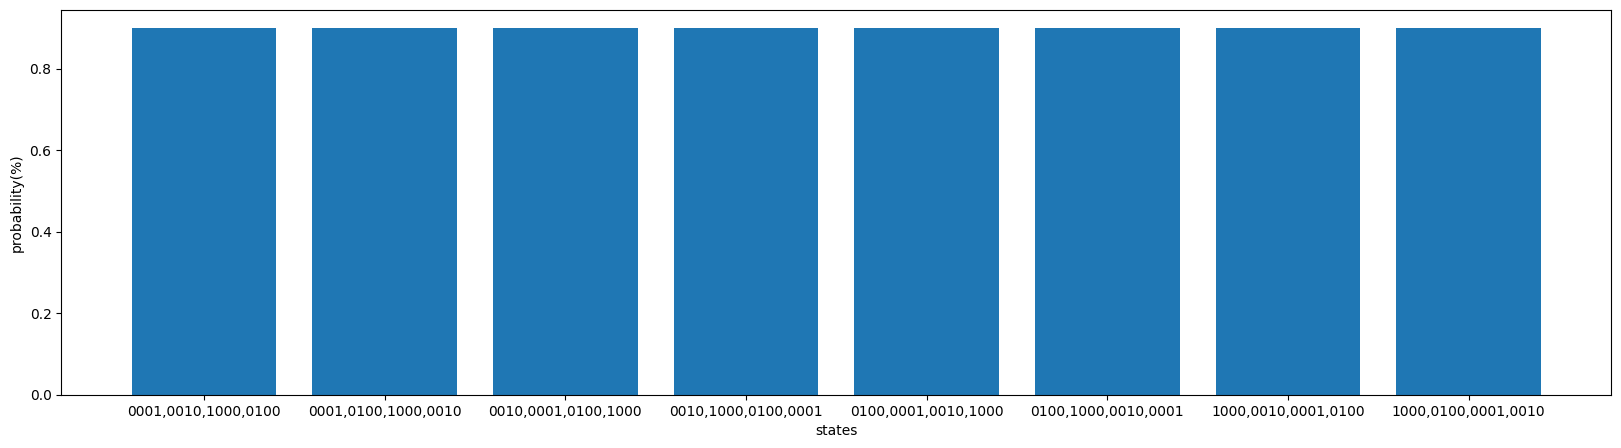

In [223]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

threshold = 0.008  # Only print values whose probability above threshold
indices = np.where(probs > threshold)[0]
z_basis_filtered = [','.join(s[i:i+int(num_qubits**0.5)] for i in range(0, len(s), int(num_qubits**0.5))) for s in [format(i, "b").zfill(num_qubits) for i in indices]]
probs_filtered = probs[indices]

plt.figure(figsize=(20, 5))
plt.xlabel("states")
plt.ylabel("probability(%)")
plt.bar(z_basis_filtered, probs_filtered * 100)
plt.show()

## How to Interpret the Measurement Histogram

After running QAOA and measuring the quantum state, you obtain a histogram where:

- **Each bar** represents a possible assignment (bitstring) of the qubits, corresponding to a candidate mapping between the two graphs.
- **The height of each bar** shows the probability of measuring that particular bitstring.

### What does this mean for graph isomorphism?

- **High-probability bitstrings** are the most likely solutions found by QAOA.
- **If the graphs are isomorphic:**  
  The histogram will show one or more bitstrings with high probability that correspond to valid permutation matrices (each row and column has exactly one '1'). These bitstrings represent isomorphisms between the graphs.
- **If the graphs are not isomorphic:**  
  No bitstring will correspond to a valid permutation matrix with zero cost, and the histogram will not show a clear, dominant solution.

### How to use the histogram:

1. **Identify the bitstrings with the highest probability.**
2. **Reshape each bitstring into an $n \times n$ matrix** (where $n$ is the number of vertices).
3. **Check if the matrix is a valid permutation matrix.**
4. **If so,** this mapping is a candidate isomorphism between the two graphs.

**Summary:**  
The histogram visually highlights which mappings QAOA considers most likely to be isomorphisms. The presence of a dominant bar (or bars) suggests a strong candidate for graph isomorphism.